In [2]:
import struct
import numpy as np
from numpy.lib.recfunctions import structured_to_unstructured

csci_types = ["FP2","FP2","FP2","FP2","FP2","FP2","IEEE4B","IEEE4B","IEEE4B","IEEE4B","FP2","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","FP2","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","IEEE4B","UINT2","UINT2","UINT2","UINT2","UINT2","UINT2","UINT2","UINT2","UINT2"]
names = ["BattV_Min","PTemp_C","TA","VP","RH","PA","SW_IN","SW_OUT","LW_IN","LW_OUT","ALB","NETRAD","NetSw","NetLw","LW_IN_Uncorr","LW_OUT_Uncorr","CNR4_Tbody_C","T_CANOPY","SI111_Tbody_C","PPFD","Judd_Ta_C","Judd_Dist","D_SNOW","WS","WD","TSN(1)","TSN(2)","TSN(3)","TSN(4)","TSN(5)","TSN(6)","TSN(7)","TSN(8)","TSN(9)","TSN(10)","TSN(11)","TSN(12)","TSN(13)","TSN(14)","VWC(1,1)","VWC(1,2)","VWC(1,3)","VWC(2,1)","VWC(2,2)","VWC(2,3)","VWC(3,1)","VWC(3,2)","VWC(3,3)","TS(1,1)","TS(1,2)","TS(1,3)","TS(2,1)","TS(2,2)","TS(2,3)","TS(3,1)","TS(3,2)","TS(3,3)","EC(1,1)","EC(1,2)","EC(1,3)","EC(2,1)","EC(2,2)","EC(2,3)","EC(3,1)","EC(3,2)","EC(3,3)","VWCCounts(1,1)","VWCCounts(1,2)","VWCCounts(1,3)","VWCCounts(2,1)","VWCCounts(2,2)","VWCCounts(2,3)","VWCCounts(3,1)","VWCCounts(3,2)","VWCCounts(3,3)","TEROS12_Diag(1,1)","TEROS12_Diag(1,2)","TEROS12_Diag(1,3)","TEROS12_Diag(2,1)","TEROS12_Diag(2,2)","TEROS12_Diag(2,3)","TEROS12_Diag(3,1)","TEROS12_Diag(3,2)","TEROS12_Diag(3,3)"]

header_nbytes = 12
footer_nbytes = 4
line_nbytes = 222
frame_nbytes = 904

data_nbytes = frame_nbytes - header_nbytes - footer_nbytes
num_fields = len(csci_types)
num_lines = data_nbytes // line_nbytes


In [3]:
with open("/Users/alex/Downloads/23313_Site4_300Sec5.dat", "rb") as f:
        for _ in range(6): f.readline()
        raw = f.read(904)[header_nbytes:-footer_nbytes]
        

In [4]:

cursor = 0  # tob3 headers are 12 bytes long
data = []
for _ in range(num_lines):
    line = []
    for csci_type, name in zip(csci_types, names):
        match csci_type:
            case "FP2":
                size = 2
                value = int.from_bytes(raw[cursor:cursor + size], "big", signed=False)
                sign = (value & 0x8000) >> 15
                exponent = (value & 0x6000) >> 13
                mantissa = value & 0x1FFF
                if (exponent == 0 and mantissa == 8191) or (sign == 1 and exponent == 0 and mantissa == 8190):
                    result = float("nan")
                else:
                    result = (-1) ** sign * 10 ** (-exponent) * float(mantissa)
            case "IEEE4B":
                size = 4    
                result = struct.unpack(">f", raw[cursor: cursor + size])[0]
            case "UINT2":
                size = 2
                result = int.from_bytes(raw[cursor:cursor + size], "big", signed=False)

        cursor += size
        line.append(result)
    data.append(line)
data_python = np.array(data)


In [5]:
def decode_fp2(u16):
    u16 = u16.astype(np.uint16, copy=False)
    sign = (u16 >> 15) & 0x1
    exponent = (u16 >> 13) & 0x3
    mantissa = u16 & 0x1FFF

    # Campbell FP2 NaN encodings
    is_nan = ((exponent == 0) & (mantissa == 8191)) | ((sign == 1) & (exponent == 0) & (mantissa == 8190))

    # (-1)^sign * 10^(-exponent) * mantissa
    result = ((-1.0) ** sign) * (10.0 ** (-exponent.astype(np.float32))) * mantissa.astype(np.float32)
    result = np.where(is_nan, np.nan, result).astype(np.float32)
    print(u16, result)
    return result

dtypes = []
for name, csci_type in zip(names, csci_types):
    match csci_type:
        case "FP2":
            dtypes.append((name, '>u2'))
            # still need to do bit manipulation to convert it to a float
        case "IEEE4B":
            dtypes.append((name, '>f4'))
        case "UINT2":
            dtypes.append((name, '>u2'))
dtype = np.dtype(dtypes)


raw_struct = np.frombuffer(raw, dtype=dtype).copy()

# Convert FP2 fields in place (or make a new dict/structured array if you prefer)
for name, csci_type in zip(names, csci_types):
    if csci_type == "FP2":
        raw_struct[name] = decode_fp2(raw_struct[name])
# Now you can stack to 2D if needed
data_numpy = structured_to_unstructured(raw_struct)

[17699 17699 17698 17698] [13.15     13.15     13.139999 13.139999]
[27846 27736 27655 27622] [3.2700002 3.16      3.0790002 3.0460002]
[28776 28976 29476 29476] [4.2000003 4.4       4.9       4.9      ]
[25185 25182 25190 25182] [0.609 0.606 0.614 0.606]
[25312 25299 25285 25274] [0.73600006 0.72300005 0.70900005 0.698     ]
[23666 23666 23665 23665] [72.82 72.82 72.81 72.81]
[40958 40958 40958 40958] [nan nan nan nan]
[26851 26935 27156 27398] [2.275     2.3590002 2.5800002 2.822    ]
[26304 26405 26420 26176] [1.728     1.8290001 1.8440001 1.6      ]
[27700 27823 28067 28259] [3.124     3.2470002 3.4910002 3.683    ]
[24576 24576 24576 24576] [0. 0. 0. 0.]
[28591 28094 29093 28595] [4.0150003 3.5180001 4.517     4.019    ]
[24990 24990 24990 24990] [0.41400003 0.41400003 0.41400003 0.41400003]
[40958 40958 40958 40958] [nan nan nan nan]
[25012 24801 25349 25304] [0.43600002 0.22500001 0.77300006 0.72800004]
[10738 10488 10709 10617] [254.6 229.6 251.7 242.5]
[40958 40958 40958 40958

/var/folders/h1/hhwj_15n5pjc0cht5mmph_y40000gn/T/ipykernel_52644/2589504807.py:34: RuntimeWarning: invalid value encountered in cast
  raw_struct[name] = decode_fp2(raw_struct[name])


In [ ]:
# TODO
# Iterate through file
# Extract the raw bytes for the header, data, and footer
# Process the footer to confirm the checksum
# If valid, stream the header and data bytes to separate buffers
# Use numpy to parse the data buffer according to the defined structure
# Don't worry about the header just yet

array([5., 5., 5., 5.], dtype=float32)

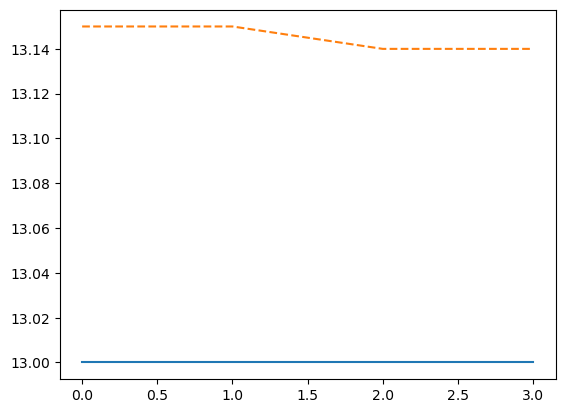

In [69]:
import matplotlib.pyplot as plt

plt.plot(data_numpy[:, 0])
plt.plot(data_python[:, 0], linestyle='dashed')